In [8]:
import numpy as np
import cv2
import os
from matplotlib import pyplot as plt
%matplotlib inline

In [82]:
def bgr2_3grey(image: np.ndarray):
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray_bgr = cv2.merge([gray_image, gray_image, gray_image])
    return gray_bgr

def stack_same_image(image_path, num_stacks=10, align=True):
    """
    Stack multiple copies of the same image to reduce noise and improve clarity.
    Optionally aligns images before stacking using ECC alignment.
    
    Parameters:
    image_path (str): Path to input image
    num_stacks (int): Number of copies to stack
    align (bool): Whether to perform image alignment
    
    Returns:
    numpy.ndarray: Enhanced image array
    """
    # Read the base image
    base_img = cv2.imread(image_path)
    if base_img is None:
        raise ValueError(f"Could not load image: {image_path}")
    
    # Convert to float32 for processing
    base_float = base_img.astype(np.float32)
    
    # Initialize accumulator
    accumulated = np.zeros_like(base_float)
    
    # Define warp matrix for alignment
    warp_mode = cv2.MOTION_EUCLIDEAN
    warp_matrix = np.eye(2, 3, dtype=np.float32)
    
    # Define alignment parameters
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 50, 0.001)
    
    # Convert base image to grayscale for alignment
    base_gray = cv2.cvtColor(base_img, cv2.COLOR_BGR2GRAY)
    
    for i in range(num_stacks):
        # Create a copy of the image with some synthetic noise
        # This simulates multiple captures of the same scene
        noisy = base_float + np.random.normal(0, 2, base_float.shape)
        
        if align and i > 0:
            # Convert current noisy image to grayscale
            current_gray = cv2.cvtColor(noisy.astype(np.uint8), cv2.COLOR_BGR2GRAY)
            
            try:
                # Find alignment between images
                _, warp_matrix = cv2.findTransformECC(
                    base_gray, 
                    current_gray,
                    warp_matrix, 
                    warp_mode, 
                    criteria,
                    inputMask=None,
                    gaussFiltSize=1
                )
                
                # Apply alignment
                height, width = base_img.shape[:2]
                noisy = cv2.warpAffine(
                    noisy, 
                    warp_matrix, 
                    (width, height), 
                    flags=cv2.INTER_LINEAR + cv2.WARP_INVERSE_MAP
                )
            except cv2.error:
                print(f"Warning: Alignment failed for stack {i+1}")
        
        # Add to accumulator
        accumulated += noisy
    
    # Calculate average
    averaged = (accumulated / num_stacks )* 2.0
    
    # Clip values and convert back to uint8
    result = np.clip(averaged, 0, 255).astype(np.uint8)
    
    return result

def save_result(averaged_image, output_path):
    """
    Save the averaged image to a file.
    
    Parameters:
    averaged_image (numpy.ndarray): Averaged image array
    output_path (str): Path where to save the result
    """
    success = cv2.imwrite(output_path, averaged_image)
    if not success:
        raise ValueError(f"Failed to save image to: {output_path}")

In [74]:
def calculate_intensity(image_path, method='all'):
    """
    Calculate the average pixel intensity of an image using different methods.
    
    Parameters:
    image_path (str): Path to input image
    method (str): Method to calculate intensity ('all', 'grayscale', 'channels')
    
    Returns:
    dict: Dictionary containing intensity values
    """
    # Read the image
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not load image: {image_path}")
    
    results = {}
    
    if method in ['all', 'grayscale']:
        # Convert to grayscale and calculate mean
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        results['grayscale_mean'] = np.mean(gray)
        results['grayscale_median'] = np.median(gray)
    
    if method in ['all', 'channels']:
        # Calculate per-channel means (BGR format)
        channel_means = cv2.mean(img)[:3]  # Exclude alpha channel if present
        results['blue_mean'] = channel_means[0]
        results['green_mean'] = channel_means[1]
        results['red_mean'] = channel_means[2]
        
        # Calculate per-channel medians
        results['blue_median'] = np.median(img[:,:,0])
        results['green_median'] = np.median(img[:,:,1])
        results['red_median'] = np.median(img[:,:,2])
        
        # Calculate overall mean
        results['overall_mean'] = np.mean(channel_means)
        
        # Calculate histogram for visualization
        results['histograms'] = [
            cv2.calcHist([img], [i], None, [256], [0, 256]) for i in range(3)
        ]
    
    return results

def print_intensity_report(image_path):
    """
    Print a detailed report of image intensity.
    
    Parameters:
    image_path (str): Path to input image
    """
    results = calculate_intensity(image_path, 'all')
    
    print(f"\nIntensity Analysis for {image_path}")
    print("-" * 50)
    print(f"Overall Mean Intensity: {results['overall_mean']:.2f}/255.0")
    print(f"Grayscale Mean: {results['grayscale_mean']:.2f}/255.0")
    print(f"Grayscale Median: {results['grayscale_median']:.2f}/255.0")
    print("\nPer-Channel Analysis:")
    print(f"Red   - Mean: {results['red_mean']:.2f}\tMedian: {results['red_median']:.2f}")
    print(f"Green - Mean: {results['green_mean']:.2f}\tMedian: {results['green_median']:.2f}")
    print(f"Blue  - Mean: {results['blue_mean']:.2f}\tMedian: {results['blue_median']:.2f}")

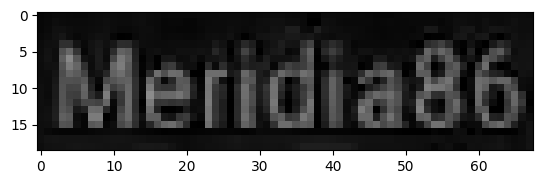

In [72]:
img = cv2.imread("/media/hbdesk/UNTITLED/penguin0/validated-annotation/names/fbf421df94d24cef8b25cda71e2f2edb.png")
img_g3 = bgr2_3grey(img)
plt.imshow(img_g3)
plt.show()

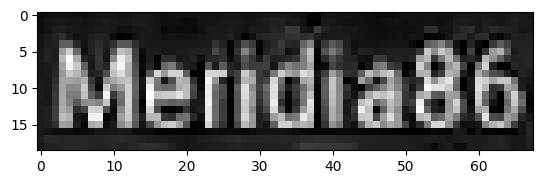

In [73]:
_a  = stack_same_image("/media/hbdesk/UNTITLED/penguin0/validated-annotation/names/fbf421df94d24cef8b25cda71e2f2edb.png")
plt.imshow(bgr2_3grey(_a))
plt.show()

In [81]:
print_intensity_report("/media/hbdesk/UNTITLED/penguin0/validated-annotation/names/fb6a3d6d00c145cb8ef98d38e3f5ad2b.png")
print_intensity_report("/media/hbdesk/UNTITLED/penguin0/validated-annotation/names/fbf421df94d24cef8b25cda71e2f2edb.png")
print_intensity_report("/media/hbdesk/UNTITLED/penguin0/validated-annotation/names/fb906929a1bf40818aa40d35b5dfdce3.png")
print_intensity_report("/media/hbdesk/UNTITLED/penguin0/validated-annotation/names/fa18633789cb42cf96994e393a8d4a42.png")


Intensity Analysis for /media/hbdesk/UNTITLED/penguin0/validated-annotation/names/fb6a3d6d00c145cb8ef98d38e3f5ad2b.png
--------------------------------------------------
Overall Mean Intensity: 60.73/255.0
Grayscale Mean: 60.59/255.0
Grayscale Median: 37.00/255.0

Per-Channel Analysis:
Red   - Mean: 63.99	Median: 41.00
Green - Mean: 59.18	Median: 35.00
Blue  - Mean: 59.02	Median: 34.00

Intensity Analysis for /media/hbdesk/UNTITLED/penguin0/validated-annotation/names/fbf421df94d24cef8b25cda71e2f2edb.png
--------------------------------------------------
Overall Mean Intensity: 33.30/255.0
Grayscale Mean: 34.00/255.0
Grayscale Median: 18.00/255.0

Per-Channel Analysis:
Red   - Mean: 36.12	Median: 19.00
Green - Mean: 33.74	Median: 18.00
Blue  - Mean: 30.05	Median: 15.00

Intensity Analysis for /media/hbdesk/UNTITLED/penguin0/validated-annotation/names/fb906929a1bf40818aa40d35b5dfdce3.png
--------------------------------------------------
Overall Mean Intensity: 90.58/255.0
Grayscale Mea